# Part1: RNN-Based Text Generation
## Objectives:
Implement a simple RNN for text generation to deepen your understanding of how re-current neural networks can be used to model sequences and generate text based on learned patterns.

- Student Name: Lyle He

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data preprocess

In [4]:
# Download the HTML file
url = "https://www.gutenberg.org/cache/epub/84/pg84-images.html"
response = requests.get(url)
html_content = response.text

# Extract text content from HTML
soup = BeautifulSoup(html_content, "html.parser")
text_content = soup.get_text()

In [5]:
start = text_content.index("You will rejoice to hear that")
end = text_content.index("*** END OF THE PROJECT GUTENBERG EBOOK FRANKENSTEIN; OR, THE MODERN PROMETHEUS ***")
text_content = text_content[start:end]
text_content = re.sub(r'CHAPTER\s\w+', '', text_content)
text_content = re.sub(r'Letter\s\w+', '', text_content)
text_content = re.sub(r'[^0-9a-zA-Z.,;!?\"\']', ' ', text_content)
# print(text_content)

In [6]:
# Tokenize the text into words
tokens = word_tokenize(text_content)

# Lowercase (and remove punctuation `if token.isalnum()`)
tokens = [token.lower() for token in tokens]
tokens[:12]

['you',
 'will',
 'rejoice',
 'to',
 'hear',
 'that',
 'no',
 'disaster',
 'has',
 'accompanied',
 'the',
 'commencement']

In [7]:
# Convert tokens to numerical format
word_to_index = {word: idx for idx, word in enumerate(set(tokens))}
index_to_word = {idx: word for word, idx in word_to_index.items()}
numerical_tokens = [word_to_index[word] for word in tokens]

# extract simples using sliding windows
window_size = 100
data = []
targets = []
for i in range(len(numerical_tokens) - window_size):
    data.append(numerical_tokens[i:i+window_size-1])
    targets.append(numerical_tokens[i+window_size-1])

In [51]:
print("word vocabulary lenght", len(word_to_index))
step = 0
for i in range(len(tokens) - window_size):
    if step > 5:
        break
    print(f"index: {step}", tokens[i:i+window_size-1][:10], "...")
    step += 1

word vocabulary lenght 7014
index: 0 ['you', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied'] ...
index: 1 ['will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the'] ...
index: 2 ['rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement'] ...
index: 3 ['to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of'] ...
index: 4 ['hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of', 'an'] ...
index: 5 ['that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of', 'an', 'enterprise'] ...


## Buidling Model

In [43]:
class BasicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(BasicRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, seq_length]
        embedded = self.embedding(x)
        # embedded: [batch_size, seq_length, embedding_dim]
        output, hidden = self.rnn(embedded)
        # output: [batch_size, seq_length, hidden_dim]
        # hidden: [1, batch_size, hidden_dim] - only considering last layer's output
        last_output = output[:, -1, :]
        # last_output: [batch_size, hidden_dim]
        prediction = self.fc(last_output)
        # prediction: [batch_size, output_dim]
        return prediction

In [44]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Replace the basic RNN with an LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, seq_length]
        embedded = self.embedding(x)
        # embedded: [batch_size, seq_length, embedding_dim]
        output, (hidden, cell) = self.lstm(embedded)
        # output: [batch_size, seq_length, hidden_dim]
        # hidden: [1, batch_size, hidden_dim] - considering the last layer's last hidden state
        # cell: [1, batch_size, hidden_dim] - considering the last layer's last cell state
        last_output = output[:, -1, :]
        # last_output: [batch_size, hidden_dim]
        prediction = self.fc(last_output)
        # prediction: [batch_size, output_dim]
        return prediction

## Training configuration

In [46]:
# Function to train the model
def train_model(model, dataloader, optimizer, loss_function, num_epochs, device):
    model.train()  # Set the model to training mode
    loss_record =[]
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Transfer data to GPU
            optimizer.zero_grad()           # Clear the gradients
            predictions = model(inputs)     # Forward pass: compute the output class given a batch of inputs
            loss = loss_function(predictions, targets)  # Compute the loss
            loss.backward()                 # Backward pass: compute the gradient of the loss w.r.t. the model's parameters
            optimizer.step()                # Perform a single optimization step (parameter update)
            total_loss += loss.item()
        loss_record.append(total_loss/len(dataloader))
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')
    return loss_record

In [11]:
import matplotlib.pyplot as plt
def plot_training_loss(title, losses_list, types):
    for i, losses in enumerate(losses_list):
        plt.plot(losses, label=f'train {types[i]}', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [26]:
# Define hyperparameters
vocab_size = len(word_to_index)
hidden_size = 128
embedding_dim = 128
output_size = len(word_to_index)
learning_rate = 0.001
num_epochs = 10
batch_size = 64
dropout = 0.3

In [13]:
# Convert data and targets to PyTorch tensors
data = torch.tensor(data, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Create DataLoader
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Trainning
### Basic RNN Model

In [47]:
# Initialize the model with the specified hyperparameters
model = BasicRNN(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_size, output_dim=output_size,dropout_rate=dropout).to(device)
print(model)
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Choose an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

BasicRNN(
  (embedding): Embedding(7014, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7014, bias=True)
)


In [48]:
# Train the model
losses_basic = train_model(model, dataloader, optimizer, loss_function, num_epochs,device)

Epoch 1/10, Loss: 5.944655305413384
Epoch 2/10, Loss: 5.131923397592664
Epoch 3/10, Loss: 4.7481588539438295
Epoch 4/10, Loss: 4.441649328299674
Epoch 5/10, Loss: 4.177625585919885
Epoch 6/10, Loss: 3.942228301919653
Epoch 7/10, Loss: 3.729293376004308
Epoch 8/10, Loss: 3.539881828695784
Epoch 9/10, Loss: 3.372912355754341
Epoch 10/10, Loss: 3.22699228919518


## USing LSTM

In [ ]:
# Initialize the model with the specified hyperparameters
lstm_Model = LSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_size, output_dim=output_size,dropout_rate=dropout).to(device)
print(lstm_Model)
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Choose an optimizer
optimizer = optim.Adam(lstm_Model.parameters(), lr=learning_rate)

In [41]:
# Train the model
loss_lstm = train_model(lstm_Model, dataloader, optimizer, loss_function, num_epochs,device)

Epoch 1/10, Loss: 5.742745469502659
Epoch 2/10, Loss: 4.944684859751572
Epoch 3/10, Loss: 4.414159628408231
Epoch 4/10, Loss: 3.9005255780375245
Epoch 5/10, Loss: 3.4474217292488207
Epoch 6/10, Loss: 3.090830279064395
Epoch 7/10, Loss: 2.804163613886115
Epoch 8/10, Loss: 2.5687731241385743
Epoch 9/10, Loss: 2.369392327744342
Epoch 10/10, Loss: 2.1992401665219026


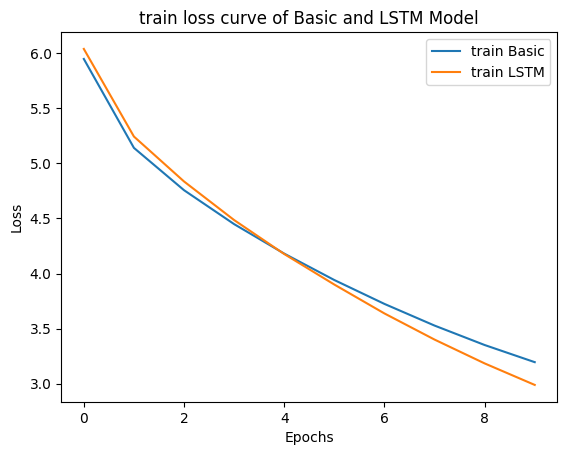

In [16]:
# // def plot_training_loss(title, losses_list, types):
plot_training_loss(title="train loss curve of Basic and LSTM Model", losses_list=[losses_basic, loss_lstm], types= ["Basic", "LSTM"])

## Generate Text Using the two Trained Model

In [17]:
def generate_text(model, seed_text, word_to_index, index_to_word, num_words=100):
    model.eval()  # Put the model in evaluation mode
    words = seed_text.split()
    for _ in range(num_words):
        # Convert words to numerical format
        input_tensor = torch.tensor([word_to_index[word] for word in words[-100:]], dtype=torch.long).unsqueeze(0).to(device)  # Assume last 100 words as context
        with torch.no_grad():
            prediction = model(input_tensor)
        # Convert prediction to word
        predicted_word_index = prediction.argmax(1).item()
        predicted_word = index_to_word[predicted_word_index]
        words.append(predicted_word)
    return ' '.join(words)

In [18]:
# Example usage:
seed_text = "I am a poor boy".lower()
generated_text = generate_text(model, seed_text, word_to_index, index_to_word, num_words=100)
print(generated_text)

i am a poor boy , and i must be rash enough to endure the hardships , and i not to be participated . i am content to be handed and transcendent . but i have no power to be handed . i have been my friend , but i was not to speak . i am not to be susceptible , and i dare not ask . i am content to be handed , and i not to be participated . i am content to be handed and transcendent . but i have no power to be handed . i have been my friend


In [19]:
# Example usage:
seed_text = "I am a poor boy".lower()
generated_text = generate_text(lstm_Model, seed_text, word_to_index, index_to_word, num_words=100)
print(generated_text)

i am a poor boy to move the cabin . the first time was not to be the sea ; and i was unable to gain the hardships who in a degree of renovating warmth which i had created . i was parched with greater speed . i am now , and i am not . i am in my eyes , and i was unable to speak . i am not . i am in my eyes , and i am now to lament . i am not . i am now to be the purport of the same , and the only that
